<a href="https://colab.research.google.com/github/ancastillar/Transformers-Create-your-own-poem-/blob/main/Transformers_Create_your_own_poem!_with_AI_Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import libraries

In [16]:
!pip install aitextgen
!pip install flask-ngrok
!pip install flask==0.12.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
import pandas as pd
import numpy as np


#Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

sns.set(rc = {'figure.figsize':(35,10)})
sns.set_palette("Paired")
sns.set_style("white")
from flask import Flask, request, render_template
from flask_ngrok import run_with_ngrok

##########Models
from aitextgen import aitextgen
import torch
import sys
import os
import random
import time 
import datetime

if torch.cuda.is_available():
    current_device = torch.cuda.current_device()
    print("Available GPUs: ", torch.cuda.get_device_name(current_device))
    print()

!nvidia-smi

import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Config, AdamW, get_linear_schedule_with_warmup, GPT2TokenizerFast
from torch.utils.data import Dataset, random_split, DataLoader, RandomSampler, SequentialSampler

Available GPUs:  Tesla T4

Sun Jul  3 17:34:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    33W /  70W |  10626MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                             

## Import Data

In [18]:
col_poem = "stanza_text"

#------------------------------------------------

df_poems = pd.read_csv("/content/drive/MyDrive/proyecto_NLP/data/poe_poems_stanzas.csv")
df_poems = df_poems[(df_poems[col_poem].notna()) & (df_poems[col_poem]!=" ")]

df_poems = df_poems.drop(137, axis=0)
print("Dimension of datase:", df_poems.shape)

Dimension of datase: (214, 2)


##📜 Global Functions

In [19]:
class PoemDataset(Dataset):
    
    def __init__(self, data, tokenizer, max_length, gpt2_type='gpt2'):
        self.tokenizer = tokenizer
        self.input_ids = []
        self.attn_masks = []
        
        for i in data:
          
            encodings_dict = tokenizer('<BOS>' + i + '<EOS>',
                                     truncation=True,
                                     max_length=max_length,
                                     padding='max_length'
                                    )

            self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
            self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

    def __len__(self):
        
        return len(self.input_ids)
    
    def __getitem__(self, idx):
        
        return self.input_ids[idx], self.attn_masks[idx]



#----------------------------------------------------------------------------------------------------------------------------------------------------

def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))
    

#-----------------------------------------------------------------------------------------------------------------------------------------------------

def train_val_split(split, dataset):

    train_size = int(split * len(dataset))
    val_size = len(dataset) - train_size
    return train_size, val_size



In [20]:
#------------------------------------------------------------------------------------------------------------------------------------------------------------------------

RANDOM_SEED = 73
BATCH_SIZE = 2
epochs = 25
MAX_LEN = 1024
home_directory = "/content/drive/MyDrive/proyecto_NLP/models"
###################################################################################################################################################################################################

pretrained_weights = 'gpt2' ## as over 1.5 billion parameters
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_weights)

special_tokens_dict = {'bos_token': '<BOS>', 'eos_token': '<EOS>', 'pad_token': '<PAD>'}
num_added_tokens = tokenizer.add_special_tokens(special_tokens_dict)

loading file https://huggingface.co/gpt2/resolve/main/vocab.json from cache at /root/.cache/huggingface/transformers/684fe667923972fb57f6b4dcb61a3c92763ad89882f3da5da9866baf14f2d60f.c7ed1f96aac49e745788faa77ba0a26a392643a50bb388b9c04ff469e555241f
loading file https://huggingface.co/gpt2/resolve/main/merges.txt from cache at /root/.cache/huggingface/transformers/c0c761a63004025aeadd530c4c27b860ec4ecbe8a00531233de21d865a402598.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/gpt2/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/gpt2/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/gpt2/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/gpt2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/fc674cd6907b4c9e933cb42d67662436b89fa9540a1f40d7c919d0109289ad01.7d2e0efa5ca20cef4fb1993821

# 🕸 Text Generation - GPT-2

In [21]:
combined_poems = df_poems.groupby(['title'])[col_poem].transform(lambda x: ''.join(x)).drop_duplicates().reset_index(drop=True)

In [22]:
max_poem_length = max([len(tokenizer.encode(poem)) for poem in combined_poems])
min_poem_length = min([len(tokenizer.encode(poem)) for poem in combined_poems])
print('Longest Poem:', max_poem_length, 'tokens long.')
print('Shortest Poem:', min_poem_length, 'tokens long.')

Token indices sequence length is longer than the specified maximum sequence length for this model (1668 > 1024). Running this sequence through the model will result in indexing errors


Longest Poem: 4427 tokens long.
Shortest Poem: 55 tokens long.


In [23]:
stanza_length = [len(tokenizer.encode(stanza)) for stanza in df_poems[col_poem].values]
max_stanza_length = max(stanza_length)
min_stanza_length = min(stanza_length)
print('Number of stanzas longer than max length: ', sum([st_len > MAX_LEN for st_len in stanza_length])) 
print('Longest Stanza:', max_stanza_length, 'tokens long.')
print('Shortest Stanza:', min_stanza_length, 'tokens long.')

Number of stanzas longer than max length:  0
Longest Stanza: 875 tokens long.
Shortest Stanza: 15 tokens long.


In [24]:
poem_dataset = PoemDataset(df_poems[col_poem].values, tokenizer, max_length=MAX_LEN)

##🐝 Train-Test Split

In [25]:
#------------------------------------------------------------------------------------------------------------------------------------

poem_train_size, poem_val_size = train_val_split(0.8, poem_dataset)

# random split imported from troch.utils
poem_train_dataset, poem_val_dataset = random_split(poem_dataset, [poem_train_size, poem_val_size])


#-------------------------------------------------------Random Seeds

torch.cuda.manual_seed_all(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

##🐝 Data Loaders

In [26]:
poem_train_dataloader = DataLoader(poem_train_dataset,
                              sampler=RandomSampler(poem_train_dataset),
                              batch_size=BATCH_SIZE)

poem_val_dataloader = DataLoader(poem_val_dataset,
                            sampler=SequentialSampler(poem_val_dataset),
                            batch_size=BATCH_SIZE)

#-------------------------------------------------------------------------------------------------------------

# helper function for logging time
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

# hyperparameters
learning_rate = 1e-4
eps = 1e-8
warmup_steps = 50
# this produces sample output every 100 steps
sample_every = 30

# create text generation seed prompt
device = torch.device('cuda')

prompt = "<BOS>"
generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

##🚀 FineTunning: Training

In [27]:
configuration = GPT2Config(vocab_size=len(tokenizer), n_positions=MAX_LEN).from_pretrained('gpt2', output_hidden_states=True)

poem_model = GPT2LMHeadModel.from_pretrained('gpt2', config=configuration)

poem_model.resize_token_embeddings(len(tokenizer))

poem_model.cuda()

# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(poem_model.parameters(), lr=learning_rate, eps=eps)

# Total number of training steps is [number of batches] x [number of epochs]. 
total_steps = len(poem_train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=warmup_steps,
                                            num_training_steps=total_steps)

#------------------------------------------------------------------------------------------------------------------

loading configuration file https://huggingface.co/gpt2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/fc674cd6907b4c9e933cb42d67662436b89fa9540a1f40d7c919d0109289ad01.7d2e0efa5ca20cef4fb199382111e9d3ad96fd77b849e1d4bed13a66e1336f51
Model config GPT2Config {
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "output_hidden_states": true,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params

In [28]:
total_t0 = time.time()

training_stats = []
total_t0 = time.time()

training_stats = []


poem_model = poem_model.to(device)

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

poem_model = poem_model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    poem_model.train()

    for step, batch in enumerate(poem_train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        poem_model.zero_grad()        

        outputs = poem_model(b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(poem_train_dataloader), batch_loss, elapsed))

            poem_model.eval()

            sample_outputs = poem_model.generate(
                                    bos_token_id= random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = MAX_LEN,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            poem_model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(poem_train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================entario
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    poem_model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in poem_val_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = poem_model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(poem_val_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

torch.save(poem_model.state_dict(), home_directory + 'poem_stanza_model.pth')


Training complete!
Total training took 0:00:00 (h:mm:ss)

======== Epoch 1 / 25 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    30  of     86. Loss: 1.192217469215393.   Elapsed: 0:00:22.
0:  Poké


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    60  of     86. Loss: 1.7561231851577759.   Elapsed: 0:00:55.
0: aven


  Average training loss: 2.33
  Training epoch took: 0:01:25

Running Validation...
  Validation Loss: 0.69
  Validation took: 0:00:05

======== Epoch 2 / 25 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    30  of     86. Loss: 1.101786732673645.   Elapsed: 0:00:22.
0:  Erdar


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    60  of     86. Loss: 0.2003844827413559.   Elapsed: 0:00:55.
0:  sensors to

  Average training loss: 0.55
  Training epoch took: 0:01:24

Running Validation...
  Validation Loss: 0.63
  Validation took: 0:00:05

======== Epoch 3 / 25 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    30  of     86. Loss: 0.401620090007782.   Elapsed: 0:00:22.
0: atility:

The joy of the new:

But no joy of the old:
By the hand of the old,
That now grows the spirit.

(


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    60  of     86. Loss: 0.58506178855896.   Elapsed: 0:00:55.
0:  heavel and

  Average training loss: 0.50
  Training epoch took: 0:01:24

Running Validation...
  Validation Loss: 0.62
  Validation took: 0:00:05

======== Epoch 4 / 25 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    30  of     86. Loss: 0.39622610807418823.   Elapsed: 0:00:22.
0:  Danny

Of

The stars in the woods
Upon a snowy night
 I saw

And saw that this forest
Was once—
 On
Twas within
The hills: and the hills did move again
That night,
 In their own chamber,
 On the night-time—
 When there was no light,
But a flickering light,—
A chamber where all things were at hand,
Were quiet, and, when they were burning,
That was a chamber,
Where all men slept,
And slept a night to a day—
And where all men fell asleep.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    60  of     86. Loss: 0.9440230131149292.   Elapsed: 0:00:55.
0:  AmongWhat is so beautiful and so unmeasurable are so many things that are so many things that are so easy—they are only in this world where the most universal joy and passion lie—but that which is a mystery to the world—a mystery to every human life! As well as such as God hath given a mystery unto them—as, the world will become known unto us!

By an eagle!
A sea of angels
Their beauty hath not extinguished—
And they will not perish!

For they will not perish!
Yet their glory will be not only the gift of God's sovereignty
And the kingdom of his angels
On whose throne this throne is held!
A golden-hearted
Whose heart loves thee more than the sun—
But the gold-hued
With whom we worship—
The gold-clad, the golden-clad,
With whom we adore.
The angel, whom the queen hath known
Of the angels, who know not how
 Of angels, whom the queen hath known
Upon which this throne there is the throne of Truth—
Upon which it is w

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    30  of     86. Loss: 0.7106380462646484.   Elapsed: 0:00:22.
0: avoriteI'll lie down on the floor of a lakeWith all my heart and all my soul to the sublime, And I'll tell of that day, and I'll believe it;And, as I sing, I'll say, I'll see it! I'll say,— 
What a melancholy!
What a melancholy! What a melancholy!
 The spirit which tells the tale,
 The spirit which tells the tale,
 When one loves a good thing.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    60  of     86. Loss: 0.2926653325557709.   Elapsed: 0:00:55.
0: cial and divine

  Average training loss: 0.46
  Training epoch took: 0:01:24

Running Validation...
  Validation Loss: 0.62
  Validation took: 0:00:05

======== Epoch 6 / 25 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    30  of     86. Loss: 0.24874833226203918.   Elapsed: 0:00:22.
0: anyahu,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    60  of     86. Loss: 0.2216719686985016.   Elapsed: 0:00:55.
0: GroupTo(start,end),start,start) {


  Average training loss: 0.45
  Training epoch took: 0:01:24

Running Validation...
  Validation Loss: 0.62
  Validation took: 0:00:05

======== Epoch 7 / 25 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    30  of     86. Loss: 1.2231088876724243.   Elapsed: 0:00:22.
0:  BeerThe bowers, all that we see, are silent; we cannot think of them, but we see them; we see them sitting in the bosom of the garden; the wild flowers, all their foliage, that float so high in the breeze, seem like those of a thousand others. It is the light in a dream, in a dream, in a dream—they are the light of a light—but, as in the dream, it is so bright that, when we


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    60  of     86. Loss: 0.18940120935440063.   Elapsed: 0:00:55.
0: iasm' to thee—

Then, all around, a sea, which hath never seen daylight before,
 Whose starry skies are lighted by the stars,
 By whose dim streams the waters flow—
 And thus that my heart may be heard,
 And that my hope may be extinguished—
 From all the glory that I now revere!

  Average training loss: 0.43
  Training epoch took: 0:01:24

Running Validation...
  Validation Loss: 0.62
  Validation took: 0:00:05

======== Epoch 8 / 25 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    30  of     86. Loss: 0.2327970266342163.   Elapsed: 0:00:22.
0:  prosecutI have sent unto thee,
 Yea,
 A woman, 
 She is my mother,
 To whom every year I cherish
 Some sweet and tender gift,
 I cherish thee—
 And now that thy birth is in my life, 
 I will remember thee forever!
 A young woman, 
 To whom a token of my love
 Thou hast known my birth, 
 And to whom my name hath been sung,
 And which, in Heaven, 
 I have known for a thousand years, 
 And that I must pass before thee with one of those solemn hymn-strings 
 Of whom I can still see a tear and a murmur—
 And thus, at last, I will not—
 And with one eye, in reality, 
 I will look on thee with the pride of a monarch,
 And with a blush of pride,
 On thy faces, amid the beauty of the skies.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    60  of     86. Loss: 0.2335754781961441.   Elapsed: 0:00:54.
0: mouth, and there,

  Average training loss: 0.42
  Training epoch took: 0:01:24

Running Validation...
  Validation Loss: 0.62
  Validation took: 0:00:05

======== Epoch 9 / 25 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    30  of     86. Loss: 0.3031338155269623.   Elapsed: 0:00:22.
0: owersI have told thee the tale of its length, when the sea went down athwart a sea, and there a man wandered among the sea."
—
In that same Annabel Lee tale—
In a rhyme, in a rhyme 
 Thence—
In that Raven's lair 
 Where the Raven of Lenore saw her,
 And then I forgot—
 Then I would not forget it.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    60  of     86. Loss: 0.13639302551746368.   Elapsed: 0:00:54.
0:  commI hope in this kingdom, 
 But I must do unto death this dream of immortality, 
 In hopes that if my soul hath a spirit in it,
 It may return to me in the dead,
 But that my brain may not live—
 And that my mind may not speak again till the last waking hour 
 Of a dead brain,— " 
 "
 "
 "— " (Edition: original; Page

  Average training loss: 0.41
  Training epoch took: 0:01:23

Running Validation...
  Validation Loss: 0.62
  Validation took: 0:00:05

======== Epoch 10 / 25 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    30  of     86. Loss: 0.32563892006874084.   Elapsed: 0:00:22.
0: nesotaGone in the light of day."
I passed his hand with a sigh, 
And he looked me upon a sober eye
Not at my pride, 
But in a state of rest, 
Upon a mellow, quiet rest.
I felt him smile—not at my heart, 
Yet at my heart,
With a gentle, radiant smile; 
 I looked upon him as I did when I saw
His beauty, with a sort of pride, 
And a sort of pride, as he looked upon me at once.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    60  of     86. Loss: 0.2969532012939453.   Elapsed: 0:00:54.
0:  waited.

  Average training loss: 0.40
  Training epoch took: 0:01:24

Running Validation...
  Validation Loss: 0.62
  Validation took: 0:00:05

======== Epoch 11 / 25 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    30  of     86. Loss: 0.2950354516506195.   Elapsed: 0:00:22.
0:  YugFor the kingdom of the holy,
 Thy holy spirit hath been shed, 
 While thy angels have been aching
 Thy soul,
 The angels—who dwell—with thee! 
 That thy spirit hath been cast 
 Like a pallid pall in thy chamber,
 Though its drapery pale 
 Is the pallor of thy tomb.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    60  of     86. Loss: 0.3309040069580078.   Elapsed: 0:00:54.
0:  tutorials'

'Let me see '
'The stars
Are shining within a crowd of travellers—
'
'And the stars will pass by on their journey'
And they shall pass by on their journey. The Heaven that is above
 Is the Raven—
 That all men may know:
'Bitter in the coldest of hours
 Of early summer—
 And the sweetest and worst of all sweets—
 Thy glory is not in the cold:——
 Thy glory is in the light
 Of early summer,
 And the Raven of Raven-haunted days
 Shall be sure— Thy delight!
 Thy pride and terror shall be known
 Thy pride and pride in the stars—
 Thy glory shall be seen!
 Thy pride and terror shall be known
 Thy pride and terror shall be seen
 Thy pride and terror shall be seen
 Thy pride and terror shall be seen
 Thy pride and terror shall be seen'
In my youthful years I dwelt in the solitude
 Of Raven-haunted nights,
 In the solitary and shadowy halls Of Raven-haunted nights 
 And in the dim and undisturbed lands of Rav

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    30  of     86. Loss: 0.47081273794174194.   Elapsed: 0:00:22.
0:  TrFelled, 
 The wind of night thro' 
 The shore of Hope's bier;
 I heard her whisper 
 Of a proud maiden, whose spirit 
 Was sweetly drawn up by her.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    60  of     86. Loss: 0.5450824499130249.   Elapsed: 0:00:54.
0:  panicWe let him flee into the dark woods 
 As if he were a queen—
 Where the mollified waters—
 Were serenity'd at her side—
 And the gush of her delight
 Like a lake of a thousand flowers in each side—
 And the mien of it—The dew
 Up to him there was an echo—
 Like the voice in the woods,
 With a quiet voice—
 With a strange melody 
 Like the gush—
 In each side of the tree
 Is the beauty of that tree—
 And the gush of her delight 
 Is the beauty of the lake in each side—
 Till then, in thine heart, I saw 
 The sweetest of all
 The flowers whose flowers sprang from the trunk—
 And all those which flew down from above
 And were all—the lovely flowers whose flowers we loved—
 And all the radiant gems, whose flowers were all—
 Each of them—the only object in Heaven.

  Average training loss: 0.39
  Training epoch took: 0:01:23

Running Validation...
  Validation Loss: 0.62
  Validation took: 0:00:05

======== Epo

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    30  of     86. Loss: 0.2370227575302124.   Elapsed: 0:00:22.
0:  exclusively"

But then, outspread that spirit
Of pride and discord that is here, 
 Forlorn and lovely,
 As if flown on a gale
 Around my throne, 
 And so long I beheld, 
 In my sleep a star—
And in my dream a thousand
Stars—that are still
 But dim and shadowy;
 My name is Liberty!"


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    60  of     86. Loss: 0.35912683606147766.   Elapsed: 0:00:54.
0: worthyBut I saw ye in his presence—
 And the angels that knew nothing—
 And saw their glory not but in the glory, 
 And the wealth not from their wealth but from their labor:
 The angels whose power were in store 
 For this world's glory: "Nevermore," said the angels, 
 "have ever known."

  Average training loss: 0.38
  Training epoch took: 0:01:23

Running Validation...
  Validation Loss: 0.62
  Validation took: 0:00:05

======== Epoch 14 / 25 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    30  of     86. Loss: 0.9646149277687073.   Elapsed: 0:00:22.
0:  mealsBy the moon-light, 
 All the flowers, 
 How strangely and faintly they bloom 
 Each year, to-night,
 O love, love this lake?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    60  of     86. Loss: 0.25442996621131897.   Elapsed: 0:00:54.
0:  tokensBalls of the skies;
But when the glory is gone 
And the bustles go down 
And the bells go down, 
My spirit is gone 
And the angels lie,
And the ghosts—I will not help 
Keeping watch over the skies."

  Average training loss: 0.36
  Training epoch took: 0:01:23

Running Validation...
  Validation Loss: 0.63
  Validation took: 0:00:05

======== Epoch 15 / 25 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    30  of     86. Loss: 0.14980226755142212.   Elapsed: 0:00:22.
0: educ" 
But they drank, and fell ill,
 And cried and knelt,
 "'Breath of the dead!
 (Come and look!)'
 Where then may spring, 
 The first woe-remenning star
 Of all the human world."


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    60  of     86. Loss: 0.23235096037387848.   Elapsed: 0:00:54.
0:  Single" in all things—the very fabric of Nature—the fabric of the human mind—the fabric of men's pride—the fabric of our pride—the fabric of our pride—
 The fabric of ours a fabric of pride—the fabric of ours a pride,

By reason of our innate nature, as the human eye knows well,—
The fabric of our pride—the fabric of it a pride—
By reason of my human nature, as the human mind knows well,—
 It would seem that no fabric of pride lies apart:
 But in what way this fabric—the fabric of it,
Which is the most common of all the human types—
The fabric of ours a pride—
The fabric of ours a pride—
 By reason of my innate nature,—
It would seem that no fabric apart from this and all the human

Habits contain pride—this God, alone, without pride
 Is in truth the only God!—
And yet no pride in pride lies apart—
To us! Love is a token of that love that cannot be broken. Love lies in the measure of the love that passes throu

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    30  of     86. Loss: 0.5345574021339417.   Elapsed: 0:00:22.
0: obe" 
 "Well, my God! 
 No more need I to speak!"
 "Nevermore!"
 "Nevermore!"
 "Nevermore!
 No more—
 Nothing more!"
 "Nevermore!"
 "Nevermore!" 

Nevermore! 
 Nevermore 
 

Nevermore

! This is the route of Hope
 Over Hell! 
 On Hope's path—
 Over Hell it is written! 
 "There is a route that holds all—
 Under Heaven—
 Over Hell it is written;
 But treads not thus: 
 Upon Heaven alone,
 Israfel
 Irafel!" 
 1849 Note Contents


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    60  of     86. Loss: 0.21182383596897125.   Elapsed: 0:00:54.
0: brance"

"Ah! wo! wo! wo! wo! wo!
 Woe! in the pit of the Mad Time—as in the throes of fire—as in the slumber of the Hell-fire."

I uttered these words so gently that the crowd—and my brain—fell within a minute or two of agreeing, when,

  Average training loss: 0.35
  Training epoch took: 0:01:23

Running Validation...
  Validation Loss: 0.63
  Validation took: 0:00:05

======== Epoch 17 / 25 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    30  of     86. Loss: 0.2928674519062042.   Elapsed: 0:00:22.
0:  ObAll lights of the sun
 Shone dimly; 
 As though from heaven on high
 I soared with the hope of a brighter Heaven
 Like a gallant knight at Rome's door. 1849 Contents p. 3


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    60  of     86. Loss: 0.16308072209358215.   Elapsed: 0:00:54.
0:  assigned'Enemy of the King!" —
And, lifting a hand in affright,
And clasping, knelt, 
On the velvet floor 
Where the King sat.
The monarch looked down upon his dead father,
 And muttered, "A new start shall start,
Upon the path of the newly-mended path." 1827 Note Contents

  Average training loss: 0.34
  Training epoch took: 0:01:24

Running Validation...
  Validation Loss: 0.64
  Validation took: 0:00:05

======== Epoch 18 / 25 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    30  of     86. Loss: 0.31913062930107117.   Elapsed: 0:00:22.
0: ipesMy heart, then, was light and sober;
 But the world was dark and sober,
 Like the stars in summer,
 Like a pallid pall on the black Earth.
 That pall was still and quiet,
 Like a shadow that fell from my chamber door,
 Like a pall in a theatre, 
 A pall in the chamber of the dead.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    60  of     86. Loss: 0.18803106248378754.   Elapsed: 0:00:55.
0: avier. 
I grew in love with her,
For a very fair maiden was there: 
What made her blush was the love 
Of a fair maiden,
For a fair maiden whom I loved well, 
I loved her for who she was,
And by her side in life, 
She loved me so well 
That when her heart was beaten 
I could no longer help laughing at her; 
Her heart sank 
In a sort of dreamy, low moan.

  Average training loss: 0.34
  Training epoch took: 0:01:25

Running Validation...
  Validation Loss: 0.65
  Validation took: 0:00:05

======== Epoch 19 / 25 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    30  of     86. Loss: 0.4165072739124298.   Elapsed: 0:00:22.
0:  totallyIt was my ambition to see that my heart grew bolder—as a poet—as a man—while, with a view to my own happiness and well-being, I wandered in the wilderness,
 In the bosom of a most remote region far above us, While some traveller intrude, as he passes,
 T'othermyr, within the bosom of the calm waters—
 'Tis a common fact of the life of man that in his solitary solitude a state of spirit
 Is not altered by its environment;
 That all the time he walks or m


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    60  of     86. Loss: 0.4211231470108032.   Elapsed: 0:00:55.
0:  slogThe Hours

And the Hours

And the Hours

Are Hours

Of my Earthly ways:
How they were wrought
 On this Earth; 
Yet
By their own power and labor, 
 They left 
And bound 
 My Earthly ways,
 To the winds—
 To the seas,
 To the skies—
 From the winds—
And from the stars—
 I flung 
 And hurled 
 A ray—
 Of light as in a dream:—

  Average training loss: 0.33
  Training epoch took: 0:01:26

Running Validation...
  Validation Loss: 0.65
  Validation took: 0:00:05

======== Epoch 20 / 25 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    30  of     86. Loss: 0.5348502397537231.   Elapsed: 0:00:22.
0:  pissedAt noon the first blush grew bright—
 As I walked upon the threshold, 
 As I reached the door, the lamp
 Shone with an intenser gleam—
 And I trembled—
 My heart weighed not—I trembled—
 But I trembled.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    60  of     86. Loss: 0.19002974033355713.   Elapsed: 0:00:55.
0: mph"

Now it trembles on the tresses of its hair
 As the moon is sinking, 
 The vapor of its pride 
 The vapor of its pride 
 Shams its pride on the weak and dead; 
 But love's venom—
 To her loveliness, to her pride
 With the venom in the winds, 
 With the venom in the floods, 
 She holds it high, 
 And the venom it caresses 
 Is with a sort of holy vow—
 But her spell
 Is with a kind of vow—
 "My dear, my forgiveness!"
 To my God my forgiveness!
 For I am thy red-lettering: 
 That my heart beats with a solemn tone—
 That my soul beats with a resolute tone, 
 And that my name is uttered, 
 "Ah, my God," says I,
 "by the voice of God."

  Average training loss: 0.32
  Training epoch took: 0:01:25

Running Validation...
  Validation Loss: 0.65
  Validation took: 0:00:05

======== Epoch 21 / 25 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    30  of     86. Loss: 0.23084066808223724.   Elapsed: 0:00:22.
0: SimilarlyA shadow on the floor 
 Hath wooed me 
 A lovely dream:
 A dreamy dream,
 And a dreamy dream 
 To which I have not long 
 Seen thee, and only thee; 
 For the very moment 
 Is gone, the dream still, 
 And I feel 
 Thy presence on my very soul, 
 Too late, for this is a dream.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    60  of     86. Loss: 0.2000531256198883.   Elapsed: 0:00:54.
0: ellig"

—Lionnaire de Condorcet, S. V.

The plot falls apart after this letter—
And, after failing, to me the solace that was in Lemnos!
Thus followed my journey down from Lem

  Average training loss: 0.32
  Training epoch took: 0:01:23

Running Validation...
  Validation Loss: 0.66
  Validation took: 0:00:05

======== Epoch 22 / 25 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    30  of     86. Loss: 0.17875109612941742.   Elapsed: 0:00:22.
0:  compassionWhen the sun came down, there was still nothing that remainedBut light, until the moon,
 As the sun did, it still dallied happily by;
 As the stars did, their destinies went unpolluted.
 The winds they left, in a myriad of forms,
 Perfumed the sky; the seas they stirred up 
 Through the air of Ghastly Stygian Stygian Stygian Stygian Stygian Stygian Stygian Stygian Stygian Stygian Stygian Stygian Stygian Stygian Stygian Stygian Stygian Stygian Stygian Stygian Stygian Stygian Stygian Stygian Stygian Stygian Stygian Stygian Stygian Stygian Stygian Stygian Stygian Stygian Stygian Stygian Stygian Stygian Stygian Stygian Stygian Stygian Stygian Stygian Stygian Stygian Stygian Stygian Stygian Stygian
 
 On Earth—I'll call it Love. 
 On God—I'll call


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    60  of     86. Loss: 0.6616799235343933.   Elapsed: 0:00:54.
0:  slatedFor the grandeur of her estate,
 I longed in dreams, 
 I long have dreamed of her—
 Her home on this rock—
 Her shore on the sea;
 She hath no bounds 
 To explore 
 That is her home—
 Wherever she may lead me!—
 No pathway o'er the calm 
 Hath left her—but the lone,
 Overlooking the tarns
 Of the tarns, tarns—
 Hath drawn me—oh, in dreams, 
 She hath not left me desolate 
 Of every shore 
 To me! 
 No shore—no shore—no cliff 
 Hath left her—
 Nor—I must confess—
 Hath striven alone—and alone—
 None of the world hath left her alone! 
 No cliff—no tarn—no dank ruin 
 Within my view—
 Nor dank shore—no dim lake 
 Within my home—
 But no tarn—no tarn—no tarn
 No tarn—no dank lake 
 Within my own!
 No tarn—no tarn—no d

  Average training loss: 0.31
  Training epoch took: 0:01:23

Running Validation...
  Validation Loss: 0.66
  Validation took: 0:00:05

======== Epoch 23 / 25 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    30  of     86. Loss: 0.24791069328784943.   Elapsed: 0:00:22.
0:  upstairsIn that shadowy garden of the valley where the mountains lie, 
 A lonely, sad maiden,
 Wrapped in a velvet pewter pall, 
 And flung in myriad pæan cushions 
 Around her, gazing at the dew-drops 
 That drip, drip, drip, drip of dew—
 Till, amid the gray dew,
 The pæan air of a funeral dirge 
 Over every lowly grave 
 Transforming itself into that dewy, maddened tomb 
 Where,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    60  of     86. Loss: 0.21566912531852722.   Elapsed: 0:00:54.
0:  grants. 1849: "This summer hath lit my spirit bright with eagle-eye," said I, "while the sun was sinking in the Stygian Stygian sea, 
 Aghast at the coming of the Lion of Tethruc-Maria, who, when all the earth was blue, lay—aghast—aghast—embryo!" 1849: "Never," I replied, "never." 1849: "Nevermore." 1849: "Nevermore."
 1849: "Nevermore." 1849: "Nevermore." 1849: "Nevermore." 1849: "Nevermore." 1849: "Nevermore."
 1849: "Nevermore." 1849: "Nevermore." 1849: "Nevermore."
 1849: "Nevermore." 1849: "Nevermore."
 1849: "Nevermore." 1849: "Nevermore." 1849: "Nevermore."
 1849: "Never

  Average training loss: 0.31
  Training epoch took: 0:01:24

Running Validation...
  Validation Loss: 0.66
  Validation took: 0:00:05

======== Epoch 24 / 25 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    30  of     86. Loss: 0.23161472380161285.   Elapsed: 0:00:22.
0:  Sixth(!) of the Age of Light
 was a garden—a shrine, in solemnest yearning called 
 Radiant Earth,
 From which the light, so called, flitting
 Bubbles, grew up and died. 
 Where the sunshine died and died, 
 The cold, the fever
 And the slumber were brought.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    60  of     86. Loss: 0.21685539186000824.   Elapsed: 0:00:54.
0:  mining.

But the storm that

  Average training loss: 0.30
  Training epoch took: 0:01:23

Running Validation...
  Validation Loss: 0.67
  Validation took: 0:00:05

======== Epoch 25 / 25 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    30  of     86. Loss: 0.2945840060710907.   Elapsed: 0:00:22.
0:  MoO! Is this the city of Athens, that is the seat of our glory—
 The grand statue, which my grand master 
 Said, 
 "Never again dost move thee,"
 But, on thy wandering hither,
 "Nevermore," I say,
 For this very spot shall be thy seat.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    60  of     86. Loss: 0.2936598062515259.   Elapsed: 0:00:54.
0:  Jr' s father, whose

  Average training loss: 0.30
  Training epoch took: 0:01:23

Running Validation...
  Validation Loss: 0.67
  Validation took: 0:00:05

Training complete!
Total training took 0:37:10 (h:mm:ss)


## 👨‍🚀 Summary of the training process

In [29]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,2.33,0.69,0:01:25,0:00:05
2,0.55,0.63,0:01:24,0:00:05
3,0.50,0.62,0:01:24,0:00:05
4,0.48,0.62,0:01:25,0:00:05
5,0.46,0.62,0:01:24,0:00:05
6,0.45,0.62,0:01:24,0:00:05
7,0.43,0.62,0:01:24,0:00:05
8,0.42,0.62,0:01:24,0:00:05
9,0.41,0.62,0:01:23,0:00:05


## 👨‍🚀 Performance Summary

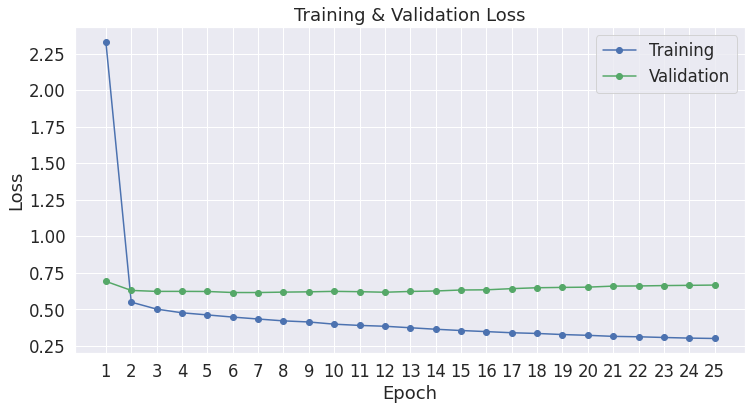

In [31]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4, 5, 6, 7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])

plt.show()

##🌌 Model Info

In [32]:
# Get all of the model's parameters as a list of tuples.
params = list(poem_model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50260, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

##  Saving & Loading Fine-Tuned Model


In [33]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = home_directory +'/model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = poem_model.module if hasattr(poem_model, 'module') else poem_model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Configuration saved in /content/drive/MyDrive/proyecto_NLP/models/model_save/config.json


Saving model to /content/drive/MyDrive/proyecto_NLP/models/model_save/


Model weights saved in /content/drive/MyDrive/proyecto_NLP/models/model_save/pytorch_model.bin
tokenizer config file saved in /content/drive/MyDrive/proyecto_NLP/models/model_save/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/proyecto_NLP/models/model_save/special_tokens_map.json
added tokens file saved in /content/drive/MyDrive/proyecto_NLP/models/model_save/added_tokens.json


('/content/drive/MyDrive/proyecto_NLP/models/model_save/tokenizer_config.json',
 '/content/drive/MyDrive/proyecto_NLP/models/model_save/special_tokens_map.json',
 '/content/drive/MyDrive/proyecto_NLP/models/model_save/vocab.json',
 '/content/drive/MyDrive/proyecto_NLP/models/model_save/merges.txt',
 '/content/drive/MyDrive/proyecto_NLP/models/model_save/added_tokens.json')

In [34]:
home_directory+'/model_save/'

'/content/drive/MyDrive/proyecto_NLP/models/model_save/'

In [35]:
!ls -l --block-size=K /content/drive/MyDrive/proyecto_NLP/models/model_save/

total 499869K
-rw------- 1 root root      1K Jul  3 18:13 added_tokens.json
-rw------- 1 root root      1K Jul  3 18:13 config.json
-rw------- 1 root root    446K Jul  3 18:13 merges.txt
-rw------- 1 root root 498444K Jul  3 18:13 pytorch_model.bin
-rw------- 1 root root      1K Jul  3 18:13 special_tokens_map.json
-rw------- 1 root root      1K Jul  3 18:13 tokenizer_config.json
-rw------- 1 root root    976K Jul  3 18:13 vocab.json


In [36]:
!ls -l --block-size=M /content/drive/MyDrive/proyecto_NLP/models/model_save/pytorch_model.bin

-rw------- 1 root root 487M Jul  3 18:13 /content/drive/MyDrive/proyecto_NLP/models/model_save/pytorch_model.bin


In [ ]:
# Copy the model files to a directory in your Google Drive.
#!cp -r /content/drive/MyDrive/proyecto_NLP/models/model_save/  $data_dir

# # Load a trained model and vocabulary that you have fine-tuned
#model = GPT2LMHeadModel.from_pretrained(output_dir)
#tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
#model.to(device)

cp: missing destination file operand after '/content/drive/MyDrive/proyecto_NLP/models/model_save/'
Try 'cp --help' for more information.


##Poems Generation

In [27]:
poem_model.eval()

prompt = 'love is'

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

sample_outputs = poem_model.generate(
                                generated, 
                                do_sample=True,   
                                top_k=40, 
                                max_length = 100,
                                top_p=0.95, 
                                num_return_sequences=3,
                                num_beams=5, no_repeat_ngram_size=4, early_stopping=True
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: love is the light of the night—
 And the shadow of the mountain 
 And the mist of the sea 
 Is a barrier—
 And a barrier that will not be broken 
 By the battle-cry 
 Of the trumpet-thunder-thunder,
 But by the roar of the battle 
 Shall be the battle cry of the dead 
 And shall be the cry of the living—
 And by the roar shall be the roar
 Of the battle-


1: love is the light of life;
It glows in the dim of night;
It flickers with the light of day,
And in the mist of day, 
It trembles with the chilly eye 
Of the lonesome and the dead.


2: love is a synonym for love,
 For love is a double-edged sword—
 And love is a gift from God—
 For the love of God is a gift of life—
 And the love of man is a gift given by God—
 And we are saved only by the grace of God."




In [29]:
poem_model.eval()

prompt = 'heaven is good'

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

sample_outputs = poem_model.generate(
                                generated, 
                                do_sample=True,   
                                top_k=40, 
                                max_length = 150,
                                top_p=0.95, 
                                num_return_sequences=3,
                                num_beams=5, no_repeat_ngram_size=4, early_stopping=True
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: heaven is good, and light is light;
And all things which are holy, 
Are light, and all things which seem 
To be a gift from God to us, 
And to us a token of our gratitude. 18
¹ ¿ 18


1: heaven is good,
And the winds are gentle, 
And the skies are clear—
And the stars seem to be smiling—
And there is no need 
To sing the hymns of the hymn-winds, 
Unless, perhaps, you are a poet or a hymn-stringer—
And you will sing the hymn of the sun-ray, 
Of the moon-ray,
Of the stars,
And there will be no need
For you to sing the song of the moon, 
 Of the stars, or of the angels, 
With the accompaniment of the bells and the bells of the bells, 
So that you may feel no need


2: heaven is good, 
 And all things are light, 
 That is, I believe, the reason 
 That all things are bright—
 And all that is gray—
 That all that is sad, 
 Is the reason that all things seem 
 To be of one essence, 
 But that all things are of one essence—
 And that all things—all things—have one essence— 
 The reason why 

In [48]:
poem_model.eval()

prompt = 'I have a dream'

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

sample_outputs = poem_model.generate(
                                generated, 
                                do_sample=True,   
                                top_k=40, 
                                max_length = 150,
                                top_p=0.95, 
                                num_return_sequences=3,
                                num_beams=5, no_repeat_ngram_size=3, early_stopping=True
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: I have a dream—a dream I can never control—
 A dream I cannot control—but a dream
 That I can't control—and a dream that I can only dream
 Of a night of rest in which I can lie—
 And a dream of a day of rest
 In which my heart beats at the thought
 Of what I have been dreaming of—
 Of the things that I have not been dreaming
 Of—what I have never been dreaming—
 Dreams that I do not know how to bring
 To pass my restlessness—
 But a dream in which my mind
 Is at rest—in which my spirit is at rest
 And I can no more lie
 Than I can at rest.


1: I have a dream—a dream—that is to be,
 A dream that I have never known—
A dream I have not seen before—
I have not dreamed of waking up,
A waking-up-to-life, 
A dreaming-out-of-life—
For I have been dreaming, dreaming,
Of waking up—
And waking up in the morning,
And dreaming of a brighter future—
Of a brighter home—
To a happier home,
To happier skies—
With a brighter heart—
 To a happier heart—with a brighter spirit—
 With a brighter mind—
 

In [57]:
poem_model.eval()

prompt = 'I have a dream'

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

sample_outputs = poem_model.generate(
                                generated, 
                                do_sample=True,   
                                top_k=50, 
                                max_length = 150,
                                top_p=0.95, 
                                num_return_sequences=3,
                                num_beams=5, no_repeat_ngram_size=2, early_stopping=True
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: I have a dream. 
 I am dreaming of a mountain—
 A mountain that trembles with the dew
 Of a demon that has tempted me,
 And has torn me from my senses. p. See! 18 p.} ¡¡ ¿¿ ½ Á½Á ÓÉ¢£$€�‑Ã±¨®°ºâánéúáóſ��ûñô¯èà�ïén


1: I have a dream—a dream of a brighter and brighter future! 18 ¤¤ ¡ ä¡¦Ó¢¢ cents pædæmmenspædin³PæDæmens pédalesñƒƓ¿pi£º½áné¨èúÃíáóÉà°â±ſ�½ �‑ ½��®§� ° 18


2: I have a dream. 
 It is a vision of the future,
 And all I can do is look on
 As it glistens on the sky—
 But what is it to me now?
 What is to be said of that dream
 That I have not seen before,?"
 Quoth the Raven, "Nevermore." p. Yes, I remember well
 The first time I panted, 1849
 Of the night I fell— 1845
 I scarcely remember it— 1846
 Was it not the dream that I had earlier
 Tamed—that I first dreamt of
 My own being— 1847
 When I was twelve


